# Data Exploration and Analysis

Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
from scipy.stats import skew, kurtosis

Importing the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
first_print_images = 'drive/MyDrive/Assignment Data/First Print'
second_print_images = 'drive/MyDrive/Assignment Data/Second Print'
image_files_first = [f for f in os.listdir(first_print_images) if f.endswith(('.png', '.jpg', '.jpeg'))]
image_files_second = [f for f in os.listdir(second_print_images) if f.endswith(('.png', '.jpg', '.jpeg'))]

image_files = [(image_files_first[i],image_files_second[i]) for i in range(len(image_files_first))]

image_data_fp = []
image_data_sp = []
for image_file_first,image_file_second in image_files:
    image_path_1 = os.path.join(first_print_images, image_file_first)
    # Load image as a numpy array
    image_1 = Image.open(image_path_1)
    image_array_1 = np.array(image_1)
    image_data_fp.append({'image_path': image_path_1, 'image_name': image_file_first, 'image': image_array_1, 'label': 'First Print'})
    image_path_2 = os.path.join(second_print_images, image_file_second)
    image_2 = Image.open(image_path_2)
    image_array_2 = np.array(image_2)
    image_data_sp.append({'image_path': image_path_2, 'image_name': image_file_second, 'image': image_array_2, 'label': 'Second Print'})

df_fp = pd.DataFrame(image_data_fp)
df_sp = pd.DataFrame(image_data_sp)


Visualizing Sample Images

In [4]:
smfp = df_fp[df_fp['image_name']=='input_image_create (2).png']['image'].iloc[0]
smsp = df_sp[df_sp['image_name']=='input_image_create (2).png']['image'].iloc[0]

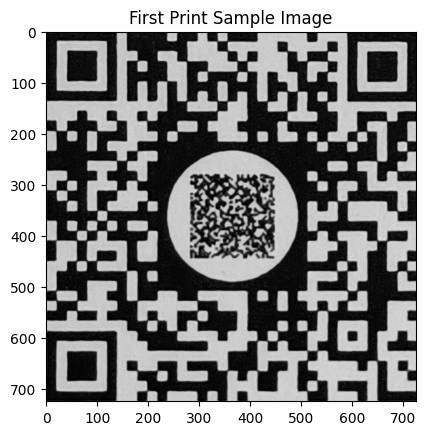

In [5]:
plt.imshow(smfp)
plt.title('First Print Sample Image')
plt.show()

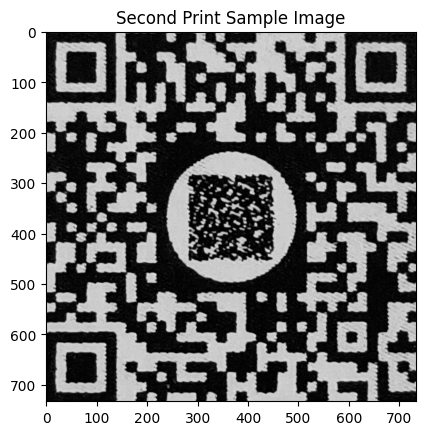

In [6]:
plt.imshow(smsp)
plt.title('Second Print Sample Image')
plt.show()

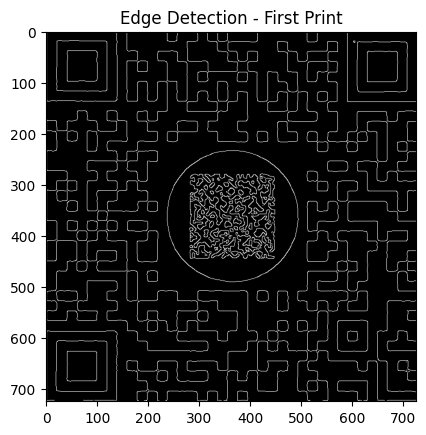

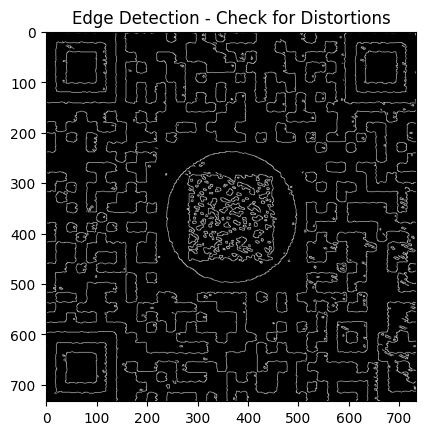

In [7]:
edges_1 = cv2.Canny(np.array(smfp), 100, 200)
edges_2 = cv2.Canny(np.array(smsp), 100, 200)

plt.imshow(edges_1, cmap='gray')
plt.title("Edge Detection - First Print")
plt.show()

plt.imshow(edges_2, cmap='gray')
plt.title("Edge Detection - Check for Distortions")
plt.show()

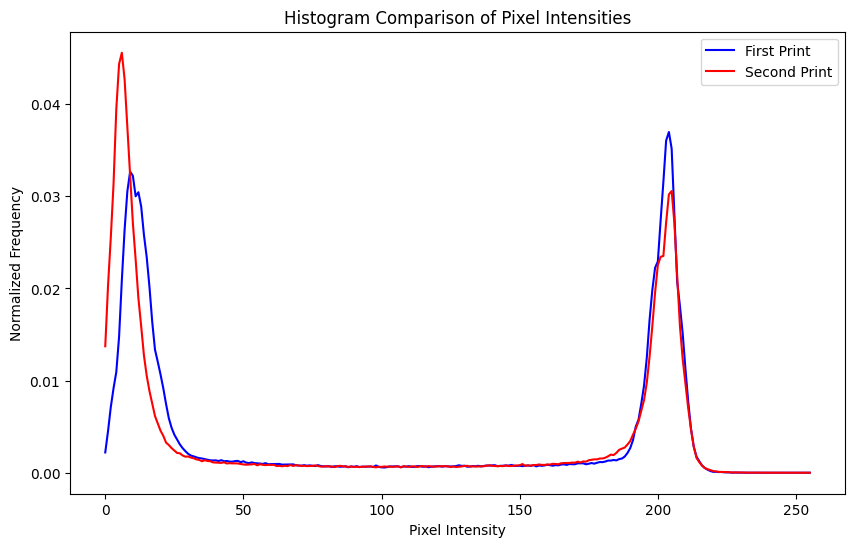

In [8]:
first_print = np.array(smfp)
second_print = np.array(smsp)

# Ensure the images are of the same size (resize if necessary)
if first_print.shape != second_print.shape:
    second_print = cv2.resize(second_print, (first_print.shape[1], first_print.shape[0]))

# Compute histograms for both images
hist_first_print = cv2.calcHist([first_print], [0], None, [256], [0, 256])
hist_second_print = cv2.calcHist([second_print], [0], None, [256], [0, 256])

# Normalize histograms (optional, but useful for better comparison)
hist_first_print /= hist_first_print.sum()
hist_second_print /= hist_second_print.sum()

# Plot the histograms for both prints
plt.figure(figsize=(10, 6))
plt.title('Histogram Comparison of Pixel Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Normalized Frequency')

# Plot both histograms
plt.plot(hist_first_print, color='blue', label='First Print')
plt.plot(hist_second_print, color='red', label='Second Print')

# Show the legend
plt.legend(loc='upper right')

# Display the plot
plt.show()

# Feature Engineering

In [9]:
df = pd.concat([df_fp,df_sp])

In [10]:
def image_features(image_path):
    image = Image.open(image_path)
    gray_image_array = np.array(image.convert('L'))
    brightness = np.mean(gray_image_array)
    contrast = np.std(gray_image_array)
    laplacian = cv2.Laplacian(gray_image_array, cv2.CV_64F)
    sharpness = laplacian.var()
    return brightness, contrast,sharpness
def compute_edge_features(image):
    # Apply Canny Edge Detection
    edges = cv2.Canny(image, 100, 200)

    # Compute Edge Features

    total_pixels = image.shape[0] * image.shape[1]
    edge_pixels = np.sum(edges > 0)  # Count white pixels (edges)
    mean_intensity = np.mean(edges)
    edge_density = edge_pixels / total_pixels
    variance_intensity = np.var(edges)

    return [edge_pixels,mean_intensity,edge_density,variance_intensity]
def compute_harris_corners(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    corners = cv2.cornerHarris(gray, 2, 3, 0.04)
    return np.sum(corners > 0.01 * corners.max())
def hough_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=10, maxLineGap=5)
    return len(lines) if lines is not None else 0
def fourier_transform_analysis(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.abs(fshift)
    return np.mean(magnitude_spectrum)

In [11]:
df['resolution'] = df['image'].apply(lambda x: x.shape)
image_features_fp = df['image_path'].apply(image_features)
df['brightness'] = image_features_fp.apply(lambda x: x[0])
df['contrast'] = image_features_fp.apply(lambda x: x[1])
df['sharpness'] = image_features_fp.apply(lambda x: x[2])
df['edge_pixels'] = df['image'].apply(compute_edge_features).apply(lambda x: x[0])
df['mean_intensity'] = df['image'].apply(compute_edge_features).apply(lambda x: x[1])
df['edge_density'] = df['image'].apply(compute_edge_features).apply(lambda x: x[2])
df['variance_intensity'] = df['image'].apply(compute_edge_features).apply(lambda x: x[3])
df['skew_intensity'] = df['image'].apply(lambda img: skew(img.flatten()))
df['kurtosis_intensity'] = df['image'].apply(lambda img: kurtosis(img.flatten()))
df['harris_corners'] = df['image'].apply(compute_harris_corners)
df['hough_lines'] = df['image'].apply(hough_lines)
df['fourier_energy'] = df['image'].apply(fourier_transform_analysis)

Important stats about data

In [15]:
df_stats = df.groupby('label').describe()

In [26]:
usable_df = df[['resolution','brightness','contrast','sharpness','edge_pixels','mean_intensity','edge_density','variance_intensity','skew_intensity','kurtosis_intensity','harris_corners','hough_lines','fourier_energy','label']]

In [27]:
usable_df['resolution'] = usable_df['resolution'].apply(lambda x:x[0])


<ipython-input-27-c04dfddc6517>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usable_df['resolution'] = usable_df['resolution'].apply(lambda x:x[0])


#Model Development

Machine Learning Models

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import cv2

# Sample DataFrame (for demonstration purposes)
# df = pd.read_csv('your_data.csv')

# 1. **Label Encoding** - Converting the labels into numeric form
label_encoder = LabelEncoder()

# Apply label encoding to 'label' column
usable_df['label_encoded'] = label_encoder.fit_transform(usable_df['label'])

# Now we have a new column 'label_encoded' that contains numeric labels
# Example: If labels were ['cat', 'dog', 'cat', 'bird'], it would convert them to [0, 1, 0, 2]

# Step 1: Extract features (drop image columns, as we are using extracted features)
X = usable_df[['resolution','brightness','contrast','sharpness','edge_pixels','mean_intensity','edge_density','variance_intensity','skew_intensity','kurtosis_intensity','harris_corners','hough_lines','fourier_energy']]

# Step 2: Prepare labels (encoded labels are now in 'label_encoded')
y = usable_df['label_encoded']

# Step 3: Normalize or scale the features (important for many models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Train-test split (typically 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 5: Train an ML model (RandomForestClassifier in this case)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Step 6: Predict on the test set
y_pred = log_reg.predict(X_test)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# If you want to see the original labels from the encoded ones, use inverse_transform
original_labels = label_encoder.inverse_transform(y_pred)
print("Predicted Labels:", original_labels)


Accuracy: 100.00%
Predicted Labels: ['First Print' 'First Print' 'First Print' 'Second Print' 'Second Print'
 'Second Print' 'First Print' 'Second Print' 'Second Print' 'First Print'
 'First Print' 'Second Print' 'Second Print' 'First Print' 'Second Print'
 'Second Print' 'First Print' 'Second Print' 'First Print' 'First Print'
 'Second Print' 'First Print' 'Second Print' 'First Print' 'First Print'
 'First Print' 'First Print' 'First Print' 'Second Print' 'Second Print'
 'First Print' 'First Print' 'First Print' 'First Print' 'Second Print'
 'Second Print' 'Second Print' 'Second Print' 'Second Print' 'First Print']


<ipython-input-32-d070e043d213>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usable_df['label_encoded'] = label_encoder.fit_transform(usable_df['label'])


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



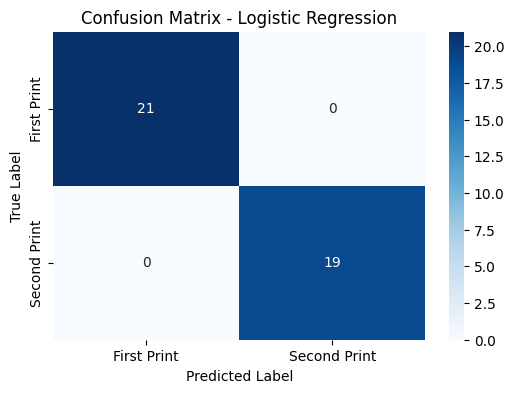

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



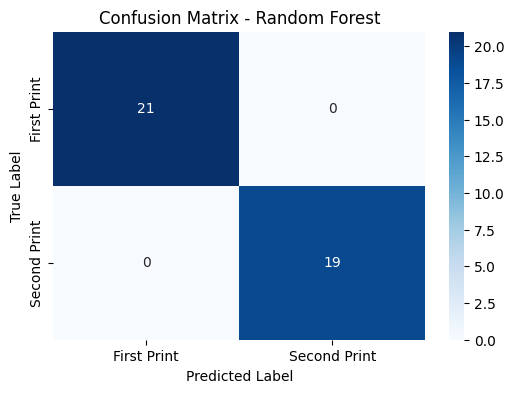

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Logistic Regression Model Evaluation
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Random Forest Model Evaluation
y_pred_rf = log_reg.predict(X_test)  # Using trained RandomForestClassifier model
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix for Random Forest
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import cv2

# Sample DataFrame (for demonstration purposes)
# df = pd.read_csv('your_data.csv')

# 1. **Label Encoding** - Converting the labels into numeric form
label_encoder = LabelEncoder()

# Apply label encoding to 'label' column
usable_df['label_encoded'] = label_encoder.fit_transform(usable_df['label'])

# Now we have a new column 'label_encoded' that contains numeric labels
# Example: If labels were ['cat', 'dog', 'cat', 'bird'], it would convert them to [0, 1, 0, 2]

# Step 1: Extract features (drop image columns, as we are using extracted features)
X = usable_df[['resolution','brightness','contrast','sharpness','edge_pixels','mean_intensity','edge_density','variance_intensity','skew_intensity','kurtosis_intensity','harris_corners','hough_lines','fourier_energy']].values

# Step 2: Prepare labels (encoded labels are now in 'label_encoded')
y = usable_df['label_encoded'].values

# Step 3: Normalize or scale the features (important for many models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Train-test split (typically 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 5: Train an ML model (RandomForestClassifier in this case)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 6: Predict on the test set
y_pred = rf.predict(X_test)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# If you want to see the original labels from the encoded ones, use inverse_transform
original_labels = label_encoder.inverse_transform(y_pred)
print("Predicted Labels:", original_labels)


<ipython-input-35-27dcc2ef174f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usable_df['label_encoded'] = label_encoder.fit_transform(usable_df['label'])


Accuracy: 100.00%
Predicted Labels: ['First Print' 'First Print' 'First Print' 'Second Print' 'Second Print'
 'Second Print' 'First Print' 'Second Print' 'Second Print' 'First Print'
 'First Print' 'Second Print' 'Second Print' 'First Print' 'Second Print'
 'Second Print' 'First Print' 'Second Print' 'First Print' 'First Print'
 'Second Print' 'First Print' 'Second Print' 'First Print' 'First Print'
 'First Print' 'First Print' 'First Print' 'Second Print' 'Second Print'
 'First Print' 'First Print' 'First Print' 'First Print' 'Second Print'
 'Second Print' 'Second Print' 'Second Print' 'Second Print' 'First Print']


Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



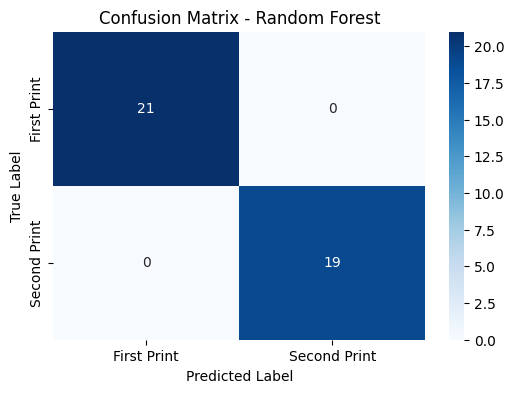

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



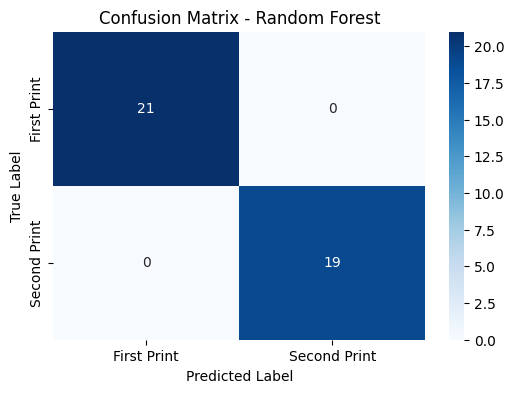

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Logistic Regression Model Evaluation
print("Random Forest Performance:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Random Forest Model Evaluation
y_pred_rf = rf.predict(X_test)  # Using trained RandomForestClassifier model
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix for Random Forest
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [37]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set image size (resize all images to same size)
IMG_SIZE = (128, 128)  # Adjust based on your dataset

# Function to read and process images
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(path)  # Read the image
        img = cv2.resize(img, IMG_SIZE)  # Resize to fixed size
        img = img / 255.0  # Normalize pixel values (0 to 1)
        images.append(img)
    return np.array(images)

# Load image data
X_images = load_images(df['image_path'])

# Convert labels to numeric format using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

# Convert labels to one-hot encoding (for CNN classification)
y_categorical = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X_images, y_categorical, test_size=0.2, random_state=42)

# CNN Model Architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')  # Output layer with softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Evaluate model performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

# Predict on test images
predictions = model.predict(X_test)

# Convert predictions back to label names
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

print("Predicted Labels:", predicted_labels)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4022 - loss: 2.5409 - val_accuracy: 0.5250 - val_loss: 0.6914
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 983ms/step - accuracy: 0.5228 - loss: 0.6998 - val_accuracy: 0.4750 - val_loss: 0.6927
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4911 - loss: 0.6913 - val_accuracy: 0.4750 - val_loss: 0.6877
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 977ms/step - accuracy: 0.5981 - loss: 0.6866 - val_accuracy: 0.4750 - val_loss: 0.6844
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5477 - loss: 0.6880 - val_accuracy: 0.5000 - val_loss: 0.6665
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 975ms/step - accuracy: 0.6265 - loss: 0.6740 - val_accuracy: 0.8500 - val_loss: 0.6458
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5984 - loss: 0.6618 - val_accuracy: 0.7500 - val_loss: 0.6455
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6879 - loss: 0.6476 - val_accuracy: 0.8750 - val_loss: 0.6125
Epoch

CNN Accuracy: 90.00%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
CNN Performance:
              precision    recall  f1-score   support

 First Print       1.00      0.81      0.89        21
Second Print       0.83      1.00      0.90        19

    accuracy                           0.90        40
   macro avg       0.91      0.90      0.90        40
weighted avg       0.92      0.90      0.90        40



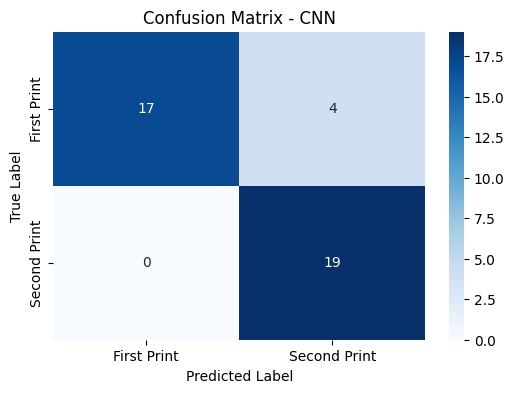

In [38]:
from tensorflow.keras.metrics import Precision, Recall

# Evaluate the CNN model
cnn_loss, cnn_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"CNN Accuracy: {cnn_accuracy * 100:.2f}%")

# Predict classes
y_pred_cnn = np.argmax(model.predict(X_test), axis=1)
y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoding back to labels

# Classification Report
print("CNN Performance:")
print(classification_report(y_test_labels, y_pred_cnn, target_names=label_encoder.classes_))

# Confusion Matrix for CNN
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_labels, y_pred_cnn), annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CNN")
plt.show()


In [39]:
from google.colab import auth
auth.authenticate_user()

!git config --global user.email "2021kucp1134@iiitkota.ac.in"
!git config --global user.name "hub-o-ag2004"


In [40]:
!git clone https://github.com/hub-o-ag2004/Qr-code-authentication.git

Cloning into 'Qr-code-authentication'...


In [43]:
!mv /content/QR_Code_Classification_Main.ipynb /content/qr-code-authentication/


mv: cannot stat '/content/QR_Code_Classification_Main.ipynb': No such file or directory


In [44]:
pwd

'/content'